In [1]:
import sys, time, os, asyncio, glob
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.time import Time, TimeDelta
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5, SkyCoord
import astropy.units as u
from lsst.obs.lsst.translators.latiss import AUXTEL_LOCATION
from lsst.obs.lsst.translators.lsst import SIMONYI_LOCATION

import lsst.afw.image as afwImage
from lsst.geom import SpherePoint
from lsst.geom import Angle as afwAngle
from astroquery.simbad import Simbad
from lsst.summit.utils.blindSolving import runImchar, genericCameraHeaderToWcs, CommandLineSolver
# This requires the tickets/DM-31175 of summit_utils

In [2]:
solver = CommandLineSolver(indexFiles='/scratch/mfisherlevine/astrometry_net/broiler.astrometry.net/~dstn/4100',
                           checkInParallel=True)

(null): Error reading magic number from Netpbm image stream.  Most often, this means your input file is empty.
(null): Error reading magic number from Netpbm image stream.  Most often, this means your input file is empty.


Fitting code ran in 3.61 seconds
SeqNum exptime timeobs timebeg timeend timegrp  Az(hdr-fix) El(header) Az(solve) El(solve) DeltaAz DeltaEl Scatter

1  2.0  2022-11-25T06:43:07.131  2022-11-25T06:43:06.131  2022-11-25T06:43:09.313  2022-11-25T06:43:05.116   180.00000      60.00000    175.96120    59.81051   4.03880   0.18949  0.907


(null): Error reading magic number from Netpbm image stream.  Most often, this means your input file is empty.
(null): Error reading magic number from Netpbm image stream.  Most often, this means your input file is empty.


Fitting code ran in 2.35 seconds
SeqNum exptime timeobs timebeg timeend timegrp  Az(hdr-fix) El(header) Az(solve) El(solve) DeltaAz DeltaEl Scatter

2  2.0  2022-11-25T06:49:52.708  2022-11-25T06:49:51.708  2022-11-25T06:49:54.891  2022-11-25T06:49:50.637   185.00000      60.00000    180.96153    59.79814   4.03847   0.20186  0.945


(null): Error reading magic number from Netpbm image stream.  Most often, this means your input file is empty.
(null): Error reading magic number from Netpbm image stream.  Most often, this means your input file is empty.


Fitting code ran in 1.97 seconds


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

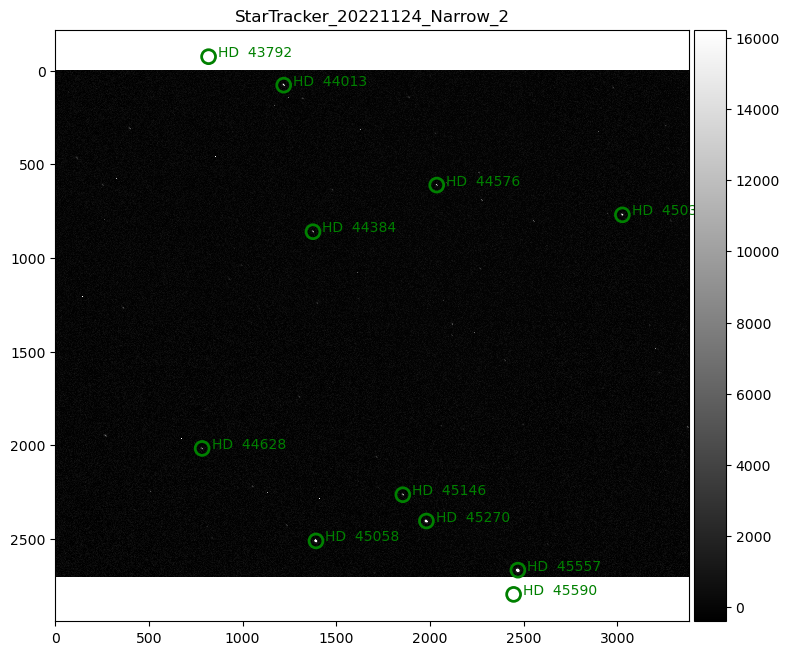

In [6]:
#cameras = [['Wide', 101], ['Narrow', 102]]
cameras = [['Narrow', 102]]
dates = [24]

#now create table
            
seqNumarray=[]
azStartarray=[]
elStartarray=[]
azarray=[]
elarray=[]
scatterarray=[]
timeobsarray=[]
timebegarray=[]
timeendarray=[]
timegrparray=[]
exptimearray=[]

# do anet fitting
for [camera, num] in cameras:
    for date in dates:
        if camera == 'Narrow' and date in [15, 16, 22]:
            # No narrow camera data in early dates
            continue

        path = f"/project/GenericCamera/{num}/2022/11/{date}/"
        for seqNum in range(1,200,1):
            try:    
                filename = path + f"GC{num}_O_202211{date}_{seqNum:06}.fits"
                exp = afwImage.ExposureF(filename)
                wcs = genericCameraHeaderToWcs(exp)
                exp.setWcs(wcs)
                results = runImchar(exp, 5, 25)
                if camera == 'Narrow':
                    # Need to loosen percentageScaleError because header SECPIX is wrong
                    solverResults = solver.run(exp, results.sourceCat,  percentageScaleError=60.0, silent=True)
                if camera == 'Wide':
                    solverResults = solver.run(exp, results.sourceCat, silent=True)
                newWcs = solverResults.wcs
                rms_error = solverResults.scatterArcseconds
                raSolve = newWcs.getSkyOrigin().getRa().asDegrees()
                decSolve = newWcs.getSkyOrigin().getDec().asDegrees()
    
            except:
                print(f"{camera}, 202211{date}_{seqNum} Failed!")
                continue
 
            # Now find simbad objects within the image
            if camera == 'Narrow':
                r = 0.7
                mag_range = 20.0
                mag_limit = 0.0
            else:
                r=4.4
                mag_range = 9.0
                mag_limit = 0.0
    
            if decSolve > 0:
                criteria = (f"region(circle,ICRS,{raSolve} +{decSolve},{r}d) & "
                    f"Vmag > {mag_limit} & Vmag < {mag_limit+mag_range} & "
                    "cat = HD")
            else:
                criteria = (f"region(circle,ICRS,{raSolve} {decSolve},{r}d) & "
                    f"Vmag > {mag_limit} & Vmag < {mag_limit+mag_range} & "
                    "cat = HD")
        
            results = Simbad.query_criteria(criteria)
            xs = []
            ys = []
            names = []

            for i in range(len(results)):
                ra = Angle(results[i][1] + 'hours')
                dec = Angle(results[i][2] + 'degrees')
                spherePoint = SpherePoint(afwAngle(ra.rad), afwAngle(dec.rad))
                point = newWcs.skyToPixel(spherePoint)
                xs.append(point.x)
                ys.append(point.y)
                name = results[i][0]
                names.append(name)
    
            # Now plot the data with matplotlib
            %matplotlib inline
            def colorbar(mappable):
                from mpl_toolkits.axes_grid1 import make_axes_locatable
                last_axes = plt.gca()
                ax = mappable.axes
                fig = ax.figure
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="5%", pad=0.05)
                cbar = fig.colorbar(mappable, cax=cax)
                plt.sca(last_axes)
                return cbar

            plt.figure(figsize=(8,8))
            plt.title(f"StarTracker_202211{date}_{camera}_{seqNum}")
            img = plt.imshow(exp.image.array,  interpolation='Nearest', cmap='gray')
            plt.scatter(xs, ys\
                ,facecolors='none', edgecolors='g', s=100, lw=2)
            for x, y, name in zip(xs, ys, names):
                plt.text(x+50,y, name, color='g')
            colorbar(img)
            plt.tight_layout(h_pad=1)
            plt.savefig(f"/home/bstalder/figures/StarTracker_Labels_Simbad_202211{date}_{camera}_{seqNum}.pdf")
            
                      
                       
            print("SeqNum exptime timeobs timebeg timeend timegrp  Az(hdr-fix) El(header) Az(solve) El(solve) DeltaAz DeltaEl Scatter\n")
            hdulist = pf.open(filename)
            header = hdulist[0].header
            raStart = header["RASTART"]
            decStart = header["DECSTART"]
            azStart = header["AZSTART"]
            azStart = 360.0 - azStart # Compensating for Az sign error
            if azStart > 360.0:
                azStart -= 360.0
            if azStart < 0.0:
                azStart += 360.0

            elStart = header["ELSTART"]
            rotpa = header["ROTPA"]
            rot = newWcs.getRelativeRotationToWcs(wcs).asDegrees()
            timeobs = Time(header["DATE-OBS"])
            timebeg = Time(header["DATE-BEG"])
            timeend = Time(header["DATE-END"])
            timegrp = Time(header["GROUPID"])
            exptime = header["EXPTIME"]
                                  
            time = timeobs + TimeDelta(exptime/2, format='sec') # - TimeDelta(37, format='sec')
            
            altAz = AltAz(obstime=time, location=SIMONYI_LOCATION)
            skyLocation = SkyCoord(raSolve * u.deg, decSolve * u.deg)
            obsAltAz = skyLocation.transform_to(altAz)
            az = obsAltAz.az.deg
            el = obsAltAz.alt.deg
            deltaAz = azStart - az
            if deltaAz > 360.0:
                deltaAz -= 360.0
            if deltaAz < 0.0:
                deltaAz += 360.0
            deltaEl = elStart - el
            scatter=solverResults.scatterArcseconds

            print(f"{seqNum}  {exptime}  {time}  {timebeg}  {timeend}  {timegrp}   {azStart:.5f}      {elStart:.5f}    {az:.5f}    {el:.5f}   {deltaAz:.5f}   {deltaEl:.5f}  {scatter:.3f}")

            seqNumarray.append(seqNum)
            azStartarray.append(azStart)
            elStartarray.append(elStart)
            azarray.append(az)
            elarray.append(el)
            scatterarray.append(scatter)
            timeobsarray.append(timeobs)
            timebegarray.append(timebeg)
            timeendarray.append(timeend)
            timegrparray.append(timegrp)
            exptimearray.append(exptime)


In [ ]:
print(time)
print(solverResults.wcs.getPixelOrigin)
print(solverResults.wcs.getSkyOrigin)
print(solverResults.plateScale)
print(SIMONYI_LOCATION)

In [ ]:
# Now find objects within the image
if camera == 'Narrow':
    r = 0.7
    mag_range = 20.0
    mag_limit = 0.0
else:
    r=4.5
    mag_range = 8.0
    mag_limit = 0.0
    
if decSolve > 0:
    criteria = (f"region(circle,ICRS,{raSolve} +{decSolve},{r}d) & "
                f"Vmag > {mag_limit} & Vmag < {mag_limit+mag_range} & "
                "cat = HD")
else:
    criteria = (f"region(circle,ICRS,{raSolve} {decSolve},{r}d) & "
                f"Vmag > {mag_limit} & Vmag < {mag_limit+mag_range} & "
                "cat = HD")
        
results = Simbad.query_criteria(criteria)
xs = []
ys = []
names = []

for i in range(len(results)):
    ra = Angle(results[i][1] + 'hours')
    dec = Angle(results[i][2] + 'degrees')
    spherePoint = SpherePoint(afwAngle(ra.rad), afwAngle(dec.rad))
    point = newWcs.skyToPixel(spherePoint)
    xs.append(point.x)
    ys.append(point.y)
    name = results[i][0]
    names.append(name)
    
# Now plot the data with matplotlib
%matplotlib inline
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

plt.figure(figsize=(8,8))
plt.title("StarTracker")
img = plt.imshow(exp.image.array,  interpolation='Nearest', cmap='gray')
plt.scatter(xs, ys\
            ,facecolors='none', edgecolors='g', s=100, lw=2)
for x, y, name in zip(xs, ys, names):
    plt.text(x+50,y, name, color='g')
colorbar(img)
plt.tight_layout(h_pad=1)
plt.savefig("/home/bstalder/figures/StarTracker_Labels_Simbad.pdf")

In [ ]:
print("SeqNum RA(header) Dec(header) RA(Solve) Dec(Solve) Az(hdr-fix) El(header) Az(solve) El(solve) DeltaAz DeltaEl Scatter\n")
hdulist = pf.open(filename)
header = hdulist[0].header
raStart = header["RASTART"]
decStart = header["DECSTART"]
azStart = header["AZSTART"]
azStart = 360.0 - azStart # Compensating for Az sign error
if azStart > 360.0:
        azStart -= 360.0
if azStart < 0.0:
        azStart += 360.0

elStart = header["ELSTART"]
rotpa = header["ROTPA"]
rot = newWcs.getRelativeRotationToWcs(wcs).asDegrees()
time = Time(header["DATE-OBS"])
altAz = AltAz(obstime=time, location=SIMONYI_LOCATION)
skyLocation = SkyCoord(raSolve * u.deg, decSolve * u.deg)
obsAltAz = skyLocation.transform_to(altAz)
az = obsAltAz.az.deg
el = obsAltAz.alt.deg
deltaAz = azStart - az
if deltaAz > 360.0:
    deltaAz -= 360.0
if deltaAz < 0.0:
    deltaAz += 360.0
deltaEl = elStart - el
scatter=solverResults.scatterArcseconds

print(f"{seqNum}   {time}   {azStart:.5f}      {elStart:.5f}    {az:.5f}    {el:.5f}   {deltaAz:.5f}   {deltaEl:.5f}  {scatter:.3f}\n")
